# RAG as a LangGraph Workflow

This notebook builds two LangGraph workflows:

**Part 1 — Ingestion pipeline:** Scrape real blog posts, chunk them, and embed into a Chroma vector store using an open-source embedding model. This shows LangGraph isn't just for agents — it's great for data pipelines too.

**Part 2 — RAG query workflow** with quality control:
- A **retrieve** node
- A **grade documents** node (LLM judges relevance)
- A **generate** node
- A **web search fallback** node (using SerpAPI)
- **Conditional routing** between them

We'll use real content from the [AI Office Hours](https://ai-office-hours.beehiiv.com/) blog as our knowledge base.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)
# Expects: OPENROUTER_API_KEY, SERPAPI_API_KEY
# Optional: LANGSMITH_API_KEY

True

## Part 1: Ingestion Pipeline as a LangGraph Workflow

Most RAG tutorials skip ingestion or hardcode documents. Here we build a **real ingestion pipeline** as a LangGraph graph:

1. **Scrape** — `WebBaseLoader` fetches blog posts from [AI Office Hours](https://ai-office-hours.beehiiv.com/)
2. **Chunk** — `RecursiveCharacterTextSplitter` breaks them into retrieval-sized pieces
3. **Embed & Store** — `HuggingFaceEmbeddings` (open-source, runs locally) + Chroma vector store

This demonstrates that LangGraph graphs aren't just for agents — they're a general-purpose orchestration framework.

In [2]:
from typing import TypedDict, Any
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langgraph.graph import StateGraph, START, END

# Blog posts from https://ai-office-hours.beehiiv.com/
BLOG_URLS = [
    "https://ai-office-hours.beehiiv.com/p/evaluating-ai-agent-tool-selection",
    "https://ai-office-hours.beehiiv.com/p/beyond-benchmarks",
    "https://ai-office-hours.beehiiv.com/p/re-ranking-rag-solutions",
    "https://ai-office-hours.beehiiv.com/p/to-quantize-or-not-to-quantize",
    "https://ai-office-hours.beehiiv.com/p/probing-llms-for-a-world-model",
    "https://ai-office-hours.beehiiv.com/p/ais-supervising-ais",
]


class IngestionState(TypedDict):
    urls: list[str]
    raw_documents: list[Document]
    chunks: list[Document]
    vectorstore: Any  # Chroma instance — passed through state for downstream use


def scrape_node(state: IngestionState) -> dict:
    """Scrape blog posts using LangChain's WebBaseLoader."""
    print(f"Scraping {len(state['urls'])} URLs...")
    loader = WebBaseLoader(state["urls"])
    docs = loader.load()
    print(f"  Loaded {len(docs)} documents")
    for doc in docs:
        title = doc.metadata.get("title", "Untitled")
        print(f"  - {title[:60]} ({len(doc.page_content)} chars)")
    return {"raw_documents": docs}


def chunk_node(state: IngestionState) -> dict:
    """Split documents into retrieval-sized chunks."""
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
        separators=["\n\n", "\n", ". ", " "],
    )
    chunks = splitter.split_documents(state["raw_documents"])
    print(f"Split {len(state['raw_documents'])} documents into {len(chunks)} chunks")
    return {"chunks": chunks}


def embed_and_store_node(state: IngestionState) -> dict:
    """Embed chunks using a local open-source model and store in Chroma."""
    # all-MiniLM-L6-v2: fast, small (80MB), runs entirely on CPU — no API key needed
    embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
    vectorstore = Chroma.from_documents(
        state["chunks"],
        embeddings,
        collection_name="ai_office_hours",
    )
    print(f"Embedded and stored {len(state['chunks'])} chunks in Chroma")
    return {"vectorstore": vectorstore}


# Build the ingestion graph
ingestion_graph = StateGraph(IngestionState)
ingestion_graph.add_node("scrape", scrape_node)
ingestion_graph.add_node("chunk", chunk_node)
ingestion_graph.add_node("embed_and_store", embed_and_store_node)

ingestion_graph.add_edge(START, "scrape")
ingestion_graph.add_edge("scrape", "chunk")
ingestion_graph.add_edge("chunk", "embed_and_store")
ingestion_graph.add_edge("embed_and_store", END)

ingestion_app = ingestion_graph.compile()

USER_AGENT environment variable not set, consider setting it to identify your requests.


### Visualize and run the ingestion pipeline

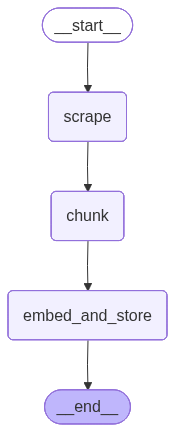

In [3]:
from IPython.display import Image, display

display(Image(ingestion_app.get_graph().draw_mermaid_png()))

### Run the ingestion pipeline

This will scrape the blog, chunk the content, and embed everything into Chroma — all orchestrated by LangGraph.

In [6]:
# Run ingestion — scrapes live blog content, chunks it, embeds with HuggingFace, stores in Chroma
result = ingestion_app.invoke({"urls": BLOG_URLS})

# Pull the vectorstore out of the graph result for use in Part 2
vectorstore = result["vectorstore"]
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

print(f"\nReady for RAG — retriever loaded with {vectorstore._collection.count()} chunks")

Scraping 6 URLs...
  Loaded 6 documents
  - Evaluating AI Agent Tool Selection (7575 chars)
  - Beyond Benchmarks (11666 chars)
  - AI Office Hours (1974 chars)
  - AI Office Hours (1980 chars)
  - AI Office Hours (1980 chars)
  - AIs Supervising AIs (5699 chars)
Split 6 documents into 46 chunks


/Users/sinanozdemir/Teaching/Pearson/oreilly-langgraph/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1717.41it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedded and stored 46 chunks in Chroma

Ready for RAG — retriever loaded with 46 chunks


## Part 2: RAG Query Workflow

Now that we have a real knowledge base, let's build a **RAG query graph** with quality control:

1. **Retrieve** — query the Chroma vector store
2. **Grade documents** — LLM judges whether each retrieved chunk is actually relevant
3. **Generate** — answer from relevant docs, OR
4. **Web search fallback** — if nothing is relevant, fall back to SerpAPI

The grading step is the key differentiator from naive RAG — we don't blindly trust the retriever.

In [7]:
from langchain_openai import ChatOpenAI
from langchain_community.utilities import SerpAPIWrapper
from pydantic import BaseModel, Field

llm = ChatOpenAI(
    model="openai/gpt-4.1",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)
grading_llm = ChatOpenAI(
    model="openai/gpt-4.1-mini",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    temperature=0,
)
serpapi = SerpAPIWrapper()


class RAGState(TypedDict):
    question: str
    documents: list[Document]
    relevant_documents: list[Document]
    web_results: str
    generation: str
    docs_relevant: bool

### RAG nodes: retrieve, grade, generate, and web search fallback

In [8]:
class GradeResult(BaseModel):
    """Binary relevance grade for a document."""
    is_relevant: bool = Field(description="Whether the document is relevant to the question")
    reasoning: str = Field(description="Brief explanation of why")


grader = grading_llm.with_structured_output(GradeResult)


def retrieve(state: RAGState) -> dict:
    """Query the Chroma vector store for relevant documents."""
    print(f"Retrieving documents for: {state['question']}")
    documents = retriever.invoke(state["question"])
    print(f"  Retrieved {len(documents)} documents")
    return {"documents": documents}


def grade_documents(state: RAGState) -> dict:
    """Grade each retrieved document for relevance using an LLM judge."""
    print("Grading document relevance...")
    relevant_docs = []

    for doc in state["documents"]:
        grade = grader.invoke(
            f"Question: {state['question']}\n\n"
            f"Document: {doc.page_content}\n\n"
            f"Is this document relevant to answering the question?"
        )
        status = "RELEVANT" if grade.is_relevant else "NOT RELEVANT"
        print(f"  [{status}] {doc.page_content[:60]}... — {grade.reasoning}")
        if grade.is_relevant:
            relevant_docs.append(doc)

    docs_relevant = len(relevant_docs) > 0
    print(f"  {len(relevant_docs)}/{len(state['documents'])} documents relevant")
    return {"relevant_documents": relevant_docs, "docs_relevant": docs_relevant}


def generate(state: RAGState) -> dict:
    """Generate an answer using the relevant documents (or web results as fallback)."""
    if state.get("web_results"):
        context = state["web_results"]
        source = "web search"
    else:
        context = "\n\n".join(doc.page_content for doc in state["relevant_documents"])
        source = "vector store"

    print(f"Generating answer from {source}...")
    response = llm.invoke(
        f"Answer the question based on the following context.\n\n"
        f"Context:\n{context}\n\n"
        f"Question: {state['question']}\n\n"
        f"Answer:"
    )
    return {"generation": response.content}


def web_search_fallback(state: RAGState) -> dict:
    """Fall back to web search when retrieved documents aren't relevant."""
    print(f"Documents not relevant — falling back to web search for: {state['question']}")
    web_content = serpapi.run(state["question"])
    print(f"  Search complete")
    return {"web_results": web_content}

### Build the RAG query graph with conditional routing

In [9]:
def route_after_grading(state: RAGState) -> str:
    """Route to generate if docs are relevant, otherwise to web search fallback."""
    if state["docs_relevant"]:
        return "generate"
    return "web_search_fallback"


# Build the RAG query graph
rag_graph = StateGraph(RAGState)

rag_graph.add_node("retrieve", retrieve)
rag_graph.add_node("grade_documents", grade_documents)
rag_graph.add_node("generate", generate)
rag_graph.add_node("web_search_fallback", web_search_fallback)

rag_graph.add_edge(START, "retrieve")
rag_graph.add_edge("retrieve", "grade_documents")

# Conditional: grade → generate OR grade → fallback → generate
rag_graph.add_conditional_edges(
    "grade_documents",
    route_after_grading,
    {
        "generate": "generate",
        "web_search_fallback": "web_search_fallback",
    },
)

rag_graph.add_edge("web_search_fallback", "generate")
rag_graph.add_edge("generate", END)

rag_app = rag_graph.compile()

### Visualize and test the RAG query graph

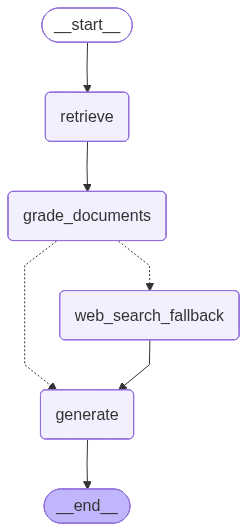

In [10]:
# The branching topology — note the conditional edge from grade_documents
display(Image(rag_app.get_graph().draw_mermaid_png()))

Test 1: A question the blog **can** answer — should retrieve relevant chunks and generate directly.

In [11]:
# Test 1: question answerable from the blog — should route directly to generate
print("=" * 60)
print("TEST 1: Question answerable from blog content")
print("=" * 60)

result = rag_app.invoke({"question": "What is positional bias in AI agents and how does it affect tool selection?"})
print(f"\nAnswer:\n{result['generation']}")

TEST 1: Question answerable from blog content
Retrieving documents for: What is positional bias in AI agents and how does it affect tool selection?
  Retrieved 3 documents
Grading document relevance...
  [RELEVANT] Evaluating AI Agent Tool SelectionAI Office HoursLoginSubscr... — The document explicitly mentions the phrase 'When you have a hammer (in the first position), everything looks like a nail,' which is a common metaphor for positional bias. It discusses AI agents selecting tools and implies that the order or position of tools affects selection, directly relating to positional bias and its effect on tool selection.
  [RELEVANT] . The Results The notebook with the test & results (see refe... — The document explicitly mentions 'Positional Bias is Real' and discusses how tool selection accuracy varies, including a graph showing differences in tool choice frequency versus correctness. This directly relates to positional bias in AI agents and its effect on tool selection.
  [RELEVANT

In [12]:
# Test 2: question answerable from the blog — different topic
print("=" * 60)
print("TEST 2: Another blog question")
print("=" * 60)

result = rag_app.invoke({"question": "What are the best practices for re-ranking in RAG systems?"})
print(f"\nAnswer:\n{result['generation']}")

TEST 2: Another blog question
Retrieving documents for: What are the best practices for re-ranking in RAG systems?
  Retrieved 3 documents
Grading document relevance...
  [NOT RELEVANT] AI Office HoursAI Office HoursLoginSubscribe404The page you ... — The document is a 404 error page indicating the requested page does not exist. It contains no information about best practices for re-ranking in RAG systems.
  [NOT RELEVANT] . I tested several from OpenAI, Anthropic, a Mistral model, ... — The document describes an experimental setup involving testing various language models and evaluating their tool selection accuracy, but it does not discuss best practices for re-ranking in Retrieval-Augmented Generation (RAG) systems.
  [NOT RELEVANT] AI Office HoursAI Office HoursLoginSubscribe404The page you ... — The document appears to be a webpage with navigation and blog post titles, but it does not contain any substantive information or best practices about re-ranking in RAG systems. Therefore,

In [13]:
# Test 3: question the blog CANNOT answer — should trigger web search fallback
print("=" * 60)
print("TEST 3: Question requiring web search fallback")
print("=" * 60)

result = rag_app.invoke({"question": "What are the latest features in LangGraph v0.4?"})
print(f"\nAnswer:\n{result['generation']}")

TEST 3: Question requiring web search fallback
Retrieving documents for: What are the latest features in LangGraph v0.4?
  Retrieved 3 documents
Grading document relevance...
  [NOT RELEVANT] 27, 2023Fine-Tuning LLaMA 2A hands-on example of fine-tuning... — The document content mentions fine-tuning LLaMA 2 and AI office hours but does not mention LangGraph or any features related to LangGraph v0.4.
  [NOT RELEVANT] 27, 2023Fine-Tuning LLaMA 2A hands-on example of fine-tuning... — The document content does not mention LangGraph or its version 0.4 features. It primarily discusses fine-tuning LLaMA 2 and related AI topics, which are unrelated to the question about LangGraph v0.4.
  [NOT RELEVANT] 27, 2023Fine-Tuning LLaMA 2A hands-on example of fine-tuning... — The document content does not mention LangGraph or its version 0.4 features. It primarily discusses fine-tuning LLaMA 2 and related AI topics, which are unrelated to the question about LangGraph v0.4.
  0/3 documents relevant
Docum

## Exercise: Add a self-correction loop

> **Exercise:** Add a **quality check** after the `generate` node. Use an LLM to check whether the generated answer is actually grounded in the context. If it's not (hallucination detected), route back to `web_search_fallback` for a second attempt.
>
> Test with:
> - `"What is positional bias in tool selection?"` → should generate from blog content and pass the quality check
> - `"What are the latest features in Python 3.14?"` → might hallucinate from blog context and trigger the self-correction loop
>
> Hints:
> - Add a `check_answer` node after `generate` that uses `with_structured_output` to assess groundedness
> - Add a conditional edge from `check_answer` → END (if grounded) or → `web_search_fallback` (if not)
> - Be careful about infinite loops — add a `retry_count` field to state and limit retries

In [14]:
# YOUR CODE HERE
